### Make necessary imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

%matplotlib inline
plt.style.use('ggplot')

#from ltests import model

### Import our combined csv into a DataFrame

In [2]:
raw = pd.read_csv('../../data/master.csv', low_memory=False, dtype={'id': object})

### We would like to select only those entries that have a sale price greater than 0

In [3]:
raw = raw[raw.SalePrice > 0]

### Now we select the sales with the proper PropertyType codes
The following is interest to us:
 - 11: Household, single family units

These are not because they don't help us answer our questions about homeownership

 - 12: Multiple family residence (Residential, 2-4 units)
 - 13: Multiple family residence (Residential, 5+ units)
 - 14: Residential condominiums
  
*These codes can be found in the Lookup.zip file located at*

https://info.kingcounty.gov/assessor/DataDownload/default.aspx 

In [4]:
proptypes = [11]

df = raw[raw.PropertyType.isin(proptypes)]

In [5]:
raw[raw.PropertyType == 14].SalePrice.describe()

count    2.217000e+03
mean     4.537666e+05
std      2.872387e+05
min      5.100000e+04
25%      2.800000e+05
50%      3.800000e+05
75%      5.500000e+05
max      4.500000e+06
Name: SalePrice, dtype: float64

### Generate our first simple model of Sale Price vs Sqft of Living Space

In [6]:
fsm_df = df[["SalePrice", "SqFtTotLiving"]].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving'
fsm = ols(formula=formula, data=fsm_df).fit()

Let's see that big table

In [7]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.187e+04
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        07:53:17   Log-Likelihood:            -2.7203e+05
No. Observations:               18807   AIC:                         5.441e+05
Df Residuals:                   18805   BIC:                         5.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.591e+04   8189.002     -1.942      0.052    -3.2e+04     144.477
SqFtTotLiving   378.6638      3.476    108.935      0.000     371.850     385.477
==============================================================================
Omnibus:                    24151.837   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12404873.130
Skew:                           6.729   Prob(JB):                         0.00
Kurtosis:                     128.096   Cond. No.                     5.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Not bad, let's check homoscedasticity**

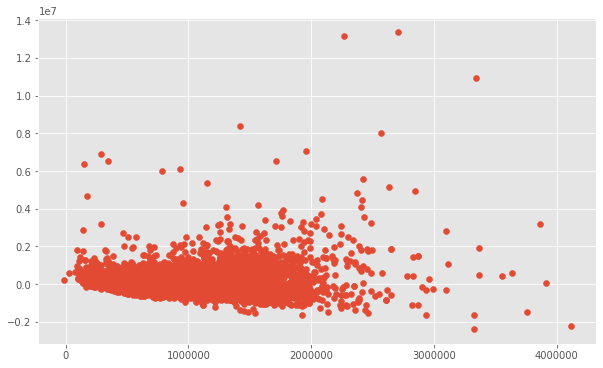

In [8]:
fsm_resids = fsm.resid
y_hat = fsm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, fsm_resids);

 - from this picture it apppears that our model is a worse predictor as homes go above 1 million dollars
 
**Let's check normality**

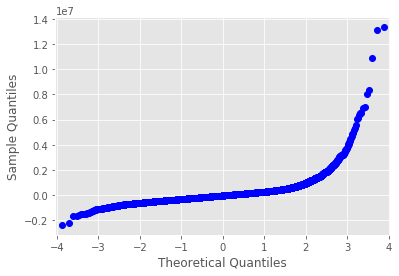

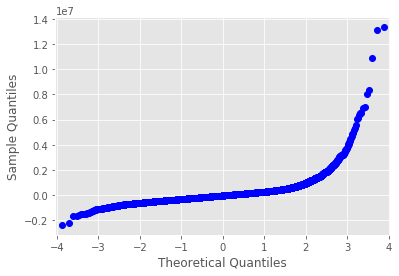

In [9]:
sm.qqplot(fsm_resids)

 - The eyeball test here is to look for a straight line, which it clearly is not!
 - This is supported by the JB p-value in the above summary table, which tells us that this is not normally distributed

### Let's try do drop some outliers 

let's remove elements with a z-score outsize of [-3,3] in either the sale price or the square foot columns

In [10]:
from scipy import stats
ssm_df = fsm_df[(np.abs(stats.zscore(fsm_df)) < 3).all(axis=1)]

In [11]:
formula = 'SalePrice ~ SqFtTotLiving'
ssm = ols(formula=formula, data=ssm_df).fit()

In [12]:
ssm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        07:53:18   Log-Likelihood:            -2.5776e+05
No. Observations:               18360   AIC:                         5.155e+05
Df Residuals:                   18358   BIC:                         5.155e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.587e+05   5933.069     26.755      0.000    1.47e+05     1.7e+05
SqFtTotLiving   279.5570      2.646    105.664      0.000     274.371     284.743
==============================================================================
Omnibus:                     3717.266   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9797.794
Skew:                           1.097   Prob(JB):                         0.00
Kurtosis:                       5.827   Cond. No.                     5.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### looks like we have a very different coefficient, but no improvement in the R^2

ssm_resids = ssm.resid
y_hat = ssm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, ssm_resids);

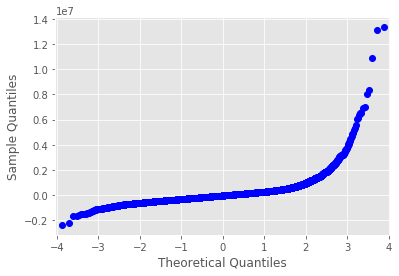

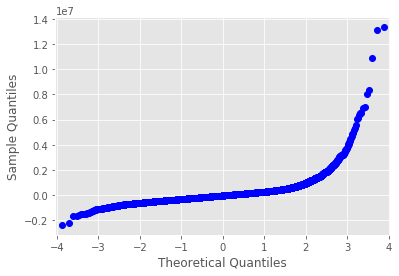

In [13]:
sm.qqplot(fsm_resids)

### Let's look at our footprint column again
we created the footprint column by taking the first floor square footage, and diving by the lot size

In [14]:
foot_df = df[["SalePrice", "footprint"]].copy()
foot_df.dropna(inplace=True)
formula = 'SalePrice ~ footprint'
footmodel = ols(formula=formula, data=foot_df).fit()

In [15]:
footmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.580
Date:                Wed, 17 Jun 2020   Prob (F-statistic):            0.00591
Time:                        07:53:19   Log-Likelihood:            -2.7662e+05
No. Observations:               18807   AIC:                         5.532e+05
Df Residuals:                   18805   BIC:                         5.533e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.771e+05   8382.167     92.707      0.000    7.61e+05    7.94e+05
footprint   1.087e+05   3.95e+04      2.753      0.006    3.13e+04    1.86e+05
==============================================================================
Omnibus:                    22410.386   Durbin-Watson:                   1.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5961811.683
Skew:                           6.062   Prob(JB):                         0.00
Kurtosis:                      89.377   Cond. No.                         9.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### We see no correlation between footprint and sale price

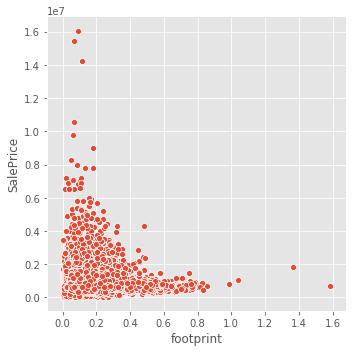

In [16]:
sns.relplot(x='footprint', y='SalePrice', data=foot_df)

### perhaps if we take the logarithm of the sale price

In [17]:
foot_df['log_price'] = np.log(foot_df.SalePrice)

In [18]:
foot_df['inv-footprint'] = np.reciprocal(foot_df.footprint)

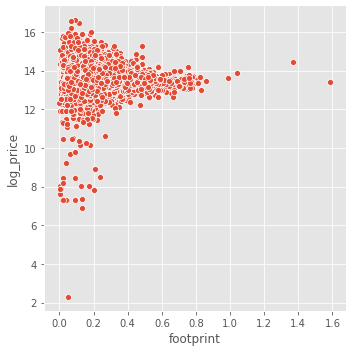

In [19]:
sns.relplot(x='footprint', y='log_price', data=foot_df)

### Maybe we can check to see how duplexes and single family homes differ

In [20]:
singlefam = df[df.PresentUse == 2]

In [21]:
duplex = df[df.PresentUse == 3]

In [22]:
duplex

,id,ExciseTaxNbr,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,footprint
622,0107000050,2978354,02/26/2019,1040000,20190320001066,,,,,,...,0.0,0.0,1950.0,0.0,0.0,0.0,0.0,3.0,0.0,0.264805
624,0108000030,3026052,12/16/2019,675000,20191218000657,,,,,,...,0.0,0.0,1953.0,0.0,0.0,0.0,0.0,2.0,0.0,0.127907
1291,0194000375,2999444,06/18/2019,650000,20190715001191,,,,,,...,0.0,0.0,1913.0,0.0,0.0,0.0,0.0,3.0,0.0,0.265252
1678,0238000125,3011992,09/23/2019,1243500,20190925001117,,,,,,...,0.0,0.0,1953.0,0.0,0.0,0.0,0.0,4.0,0.0,0.054330
1689,0240000043,3006168,08/08/2019,350000,20190821001294,,,,,,...,0.0,0.0,1954.0,0.0,0.0,0.0,0.0,3.0,0.0,0.116586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60286,9418400280,2971432,01/04/2019,575000,,,,,,,...,0.0,0.0,1943.0,0.0,0.0,0.0,0.0,3.0,0.0,0.257440
61156,9530100025,3023993,12/02/2019,1175000,20191205001119,,,,,,...,0.0,1.0,1956.0,0.0,0.0,0.0,0.0,3.0,0.0,0.201333
61441,9550204640,3010127,08/30/2019,1220000,20190913001236,,,,,,...,0.0,0.0,1929.0,0.0,0.0,0.0,0.0,4.0,0.0,0.365762
61935,9831200350,3009245,08/29/2019,960000,20190909000967,,,,,,...,0.0,0.0,1906.0,0.0,0.0,0.0,0.0,3.0,0.0,0.238889


In [23]:
duplexdf = duplex[["SalePrice", "SqFtTotLiving"]].copy()
duplexdf.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving'
dfsm = ols(formula=formula, data=duplexdf).fit()

### check the relationship between the square footage in a duplex and its sale price


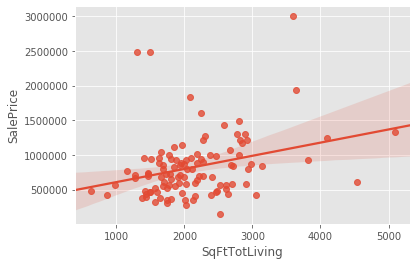

In [24]:
sns.regplot(x='SqFtTotLiving', y='SalePrice', data=duplexdf)

### let's drop some outliers

In [25]:
ddf = duplexdf[(np.abs(stats.zscore(duplexdf)) < 3).all(axis=1)]

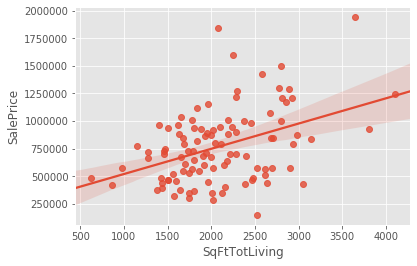

In [26]:
sns.regplot(x='SqFtTotLiving', y='SalePrice', data=ddf)

In [27]:
duplexmodel = ols(formula=formula, data=ddf).fit()

In [28]:
duplexmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     20.78
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           1.44e-05
Time:                        07:53:21   Log-Likelihood:                -1459.8
No. Observations:                 104   AIC:                             2924.
Df Residuals:                     102   BIC:                             2929.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.907e+05   1.09e+05      2.668      0.009    7.46e+04    5.07e+05
SqFtTotLiving   228.8861     50.213      4.558      0.000     129.289     328.483
==============================================================================
Omnibus:                        9.464   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.871
Skew:                           0.590   Prob(JB):                      0.00719
Kurtosis:                       3.941   Cond. No.                     7.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
df.ZipCode.unique()

array([nan, '98002', '98166', '98032', '98168', '98144', '98055', '98122',
       '98115', '98007', '98052', '98042', '98108', '98040', '98136',
       '98126', '98188', '98023', '98058', '98058 ', '98116', '98146',
       '98103', '98075', '98024', '98003', '98031', '98117', '98177',
       '98019', '98028', '98028-6100', '98033', '98092', '98070', '98038',
       '98107', '98106', '98059', '98008', '98133', '98072', '98001',
       '98125', '98022', '98178', '98034', '98102', '98045', '98030',
       '98148', '98011', '98005', '98053', '98118', '98065', '98075-8010',
       '98027', '98077', '98004', '98074', '98199', '98056', '98029',
       '98051', '98198', '98155', '98006', '98010', '98105', '98109',
       '98039', '98047', '98014', '98112', '98119', '98074-3908', '91844',
       '98058-5344', '98113', '98023-7841', '98', '98050', '98057',
       '98079', '98288', '98354', '98074-6745', '98042-3001', '98134',
       '98224', '98034-2540', '98103-8173', '988122'], dtype=object)

### Curious to check out the relationship between zip code and sale price

In [30]:
zipcode_df = df[['SalePrice', 'SqFtTotLiving', 'ZipCode']].copy()
zipcode_df.dropna(inplace=True)
zipcode_df['ZipCode'] = zipcode_df['ZipCode'].str.slice(0,5)
zipcode_df.ZipCode.unique()

array(['98002', '98166', '98032', '98168', '98144', '98055', '98122',
       '98115', '98007', '98052', '98042', '98108', '98040', '98136',
       '98126', '98188', '98023', '98058', '98116', '98146', '98103',
       '98075', '98024', '98003', '98031', '98117', '98177', '98019',
       '98028', '98033', '98092', '98070', '98038', '98107', '98106',
       '98059', '98008', '98133', '98072', '98001', '98125', '98022',
       '98178', '98034', '98102', '98045', '98030', '98148', '98011',
       '98005', '98053', '98118', '98065', '98027', '98077', '98004',
       '98074', '98199', '98056', '98029', '98051', '98198', '98155',
       '98006', '98010', '98105', '98109', '98039', '98047', '98014',
       '98112', '98119', '91844', '98113', '98', '98050', '98057',
       '98079', '98288', '98354', '98134', '98224', '98812'], dtype=object)

### let's make dummy variables out of our 83 zip codes

In [31]:
zipdums = pd.get_dummies(zipcode_df['ZipCode'], drop_first=True)
zip_df = pd.concat([zipcode_df, zipdums], axis=1)


In [32]:
zip_df = zip_df.drop(columns=['98', 'ZipCode'])

### We'll try to see if adding a bathroom count to our model can improve it

In [44]:
df['bathrooms'] = df.BathHalfCount + df.Bath3qtrCount + df.BathFullCount

C:\Users\jaker\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
fsm_df = df[["SalePrice", "SqFtTotLiving", 'bathrooms']].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving  + bathrooms '
fsm = ols(formula=formula, data=fsm_df).fit()

In [46]:
fsm.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     5955.
Date:                Wed, 17 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:07:48   Log-Likelihood:            -2.7201e+05
No. Observations:               18807   AIC:                         5.440e+05
Df Residuals:                   18804   BIC:                         5.441e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -3.97e+04   9399.471     -4.224      0.000   -5.81e+04   -2.13e+04
SqFtTotLiving   357.1903      5.429     65.788      0.000     346.548     367.832
bathrooms       2.71e+04   5266.766      5.146      0.000    1.68e+04    3.74e+04
==============================================================================
Omnibus:                    24183.808   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12469033.634
Skew:                           6.745   Prob(JB):                         0.00
Kurtosis:                     128.419   Cond. No.                     6.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
np.cov(fsm_df.bathrooms, fsm_df.SqFtTotLiving)

array([[1.00189705e+00, 7.46938086e+02],
       [7.46938086e+02, 9.42759923e+05]])